In [1]:
import getpass
import os


from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

# 加载环境变量
load_dotenv(override=False)  # override=False 避免.env覆盖系统环境变量

model = ChatOpenAI(
    model=os.getenv("MODEL_NAME"),
    temperature=0.5,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url=os.getenv("BASE_URL")
)

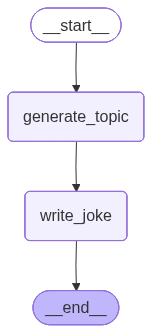

In [2]:
import uuid

from typing_extensions import TypedDict, NotRequired
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    topic: NotRequired[str]
    joke: NotRequired[str]


def generate_topic(state: State):
    """LLM call to generate a topic for the joke"""
    msg = model.invoke("Give me a funny topic for a joke")
    return {"topic": msg.content}


def write_joke(state: State):
    """LLM call to write a joke based on the topic"""
    msg = model.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_topic", generate_topic)
workflow.add_node("write_joke", write_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_topic")
workflow.add_edge("generate_topic", "write_joke")
workflow.add_edge("write_joke", END)

# Compile
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
graph

### 针对上述Workflow，我们依次执行：1、运行图；2、确认检查点；3、更新状态；4、从检查点恢复执行

运行图

In [3]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}
state = graph.invoke({}, config)

print(state["topic"])
print()
print(state["joke"])

Here are some funny topic ideas for a joke, playing on different types of humor:

**Relatable Annoyances:**

* **The never-ending "agree to terms and conditions" scroll.** (Especially for a free trial you'll forget to cancel.)
* **Trying to assemble IKEA furniture with only the pictograms.** (And a growing sense of existential dread.)
* **The bizarre things people say in online reviews.** (Especially for something mundane like a stapler.)
* **That one friend who always overshares on social media.** (Their entire life story, in excruciating detail.)
* **The struggle of trying to open a plastic package.** (It's a battle of wills, and the plastic always wins.)
* **People who talk on speakerphone in public.** (Especially when it's a very personal conversation.)
* **The sheer absurdity of autocorrect.** (Turning innocent texts into accidental insults.)
* **Trying to explain technology to your parents/grandparents.** (And their subsequent, often hilarious, misunderstandings.)

**Absurd Situa

确认检查点

In [4]:
# The states are returned in reverse chronological order.
states = list(graph.get_state_history(config))

for state in states:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print()

()
1f0da5aa-2cbe-6181-8002-f3ddf5bed865

('write_joke',)
1f0da5aa-1d74-6720-8001-8e278ce5e03c

('generate_topic',)
1f0da5a9-e2dd-683e-8000-6f5cd434515f

('__start__',)
1f0da5a9-e2d7-69d3-bfff-1984dbc0cdb9



In [5]:
# This is the state before last (states are listed in chronological order)
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)

('write_joke',)
{'topic': 'Here are some funny topic ideas for a joke, playing on different types of humor:\n\n**Relatable Annoyances:**\n\n* **The never-ending "agree to terms and conditions" scroll.** (Especially for a free trial you\'ll forget to cancel.)\n* **Trying to assemble IKEA furniture with only the pictograms.** (And a growing sense of existential dread.)\n* **The bizarre things people say in online reviews.** (Especially for something mundane like a stapler.)\n* **That one friend who always overshares on social media.** (Their entire life story, in excruciating detail.)\n* **The struggle of trying to open a plastic package.** (It\'s a battle of wills, and the plastic always wins.)\n* **People who talk on speakerphone in public.** (Especially when it\'s a very personal conversation.)\n* **The sheer absurdity of autocorrect.** (Turning innocent texts into accidental insults.)\n* **Trying to explain technology to your parents/grandparents.** (And their subsequent, often hilar

更新状态

In [6]:
new_config = graph.update_state(selected_state.config, values={"topic": "chickens"})
print(new_config)

{'configurable': {'thread_id': '551230ab-d4fd-482e-9d12-3e87d994b837', 'checkpoint_ns': '', 'checkpoint_id': '1f0da5aa-f30c-62d7-8002-a37c0625170e'}}


恢复执行

In [7]:
graph.invoke(None, new_config)

{'topic': 'chickens',
 'joke': 'Why did the chicken cross the playground? \n\\\n… To get to the other slide!'}